In [7]:
import os
import pandas as pd 
import pickle
from tqdm import tqdm 
import data_extraction as datrac
import sr_processing as sr
from time import time
import numpy as np

In [8]:
def psth_cal(trial_arrays):
    stacked_trial_rates = np.stack(trial_arrays, axis=0)
    per_neuron_psth = np.mean(stacked_trial_rates, axis=0)
    return per_neuron_psth

In [9]:
main_path = '/scratch/'
time_res = 0.01
bin_size = time_res
data_path = os.path.join(main_path,'data.pkl')
epoch_path = os.path.join(main_path,'epochs.pkl')
photostim_path = os.path.join(main_path,'photostim.pkl')
visualstim_path = os.path.join(main_path,'visualstim.pkl')
df_data = pd.read_pickle(data_path)
df_epoch = pd.read_pickle(epoch_path)
df_photostim = pd.read_pickle(photostim_path)
df_visualstim = pd.read_pickle(visualstim_path)

In [10]:
# extract the timging for each events
#stim_ep = 'RFMapping_1'
t1 = time()
stims_eps = ['RFMapping_0','RFMapping_1','RFMapping_2']
for stim_ep in stims_eps:
    df_map_save  =  f'/scratch/{stim_ep}/'
    stim_ep_path = f'{df_map_save}raw'
    save_path = f'/scratch/{stim_ep}/firing_rate2'
    df_interest = datrac.update_stim_eps_end_time(df_visualstim,stim_ep)
    df_interest.to_csv(os.path.join(df_map_save,'trial_info.csv'))
    datrac.extract_spikes_times_parallel_optimized(df_data,df_interest, stim_ep, main_path)
    datrac.parallel_bin_spikes(stim_ep_path, save_path, time_res, num_processes=None)
#stims_eps = 'RFMapping_2'
bin_size = 0.005
stim_ep_list = ['RFMapping_0','RFMapping_1','RFMapping_2']
for stims_eps in stim_ep_list:
    epochs_path = f'/scratch/{stims_eps}/'
    fr_path = f'{epochs_path}/firing_rate2/'
    trial_path = os.path.join(epochs_path,'trial_info.csv')
    df_trials = pd.read_csv(trial_path,index_col='Unnamed: 0')
    index_map = sr.get_index_maps(df_trials)
    results_dic ={}
    pbar = tqdm(total = len(index_map.keys()),leave=True, position=0)
    for inds in index_map.keys():
        trials2avg = index_map[inds]
        data_set = {d_ind:sr.get_spikerate_data(f'{fr_path}trial_array_{d_ind}.pkl') for d_ind in trials2avg}
        if len(set([d['bin_centers'].shape[0] for d in data_set.values()])) != 1:
            data_set = sr.trim_binsz_ts(data_set)
        temp_results =psth_cal([trial['s_counts'] for trial in data_set.values()])/bin_size
        results_dic[inds] = sr.spike_rate_zscore(temp_results)
        pbar.update(1)
    filename = f'{epochs_path}firing_rates.pkl'
    pickle.dump(results_dic, open(filename, 'wb'))
t2 = time()
print(t2-t1)

Processing Trials: 100%|██████████| 2322/2322 [00:04<00:00, 544.00it/s]


Processing for RFMapping_0 complete. Files saved in /scratch/RFMapping_0/raw
Starting parallel processing with 16 cores...


100%|██████████| 2322/2322 [00:23<00:00, 99.11it/s] 



--- Processing Log ---
All files processed successfully.
----------------------


Processing Trials: 100%|██████████| 2322/2322 [00:04<00:00, 527.67it/s]


Processing for RFMapping_1 complete. Files saved in /scratch/RFMapping_1/raw
Starting parallel processing with 16 cores...


100%|██████████| 2322/2322 [00:23<00:00, 99.54it/s] 



--- Processing Log ---
All files processed successfully.
----------------------


Processing Trials: 100%|██████████| 2322/2322 [00:04<00:00, 505.08it/s]


Processing for RFMapping_2 complete. Files saved in /scratch/RFMapping_2/raw
Starting parallel processing with 16 cores...


100%|██████████| 2322/2322 [00:23<00:00, 98.58it/s] 



--- Processing Log ---
All files processed successfully.
----------------------


 99%|█████████▉| 192/193 [00:06<00:00, 29.25it/s]

119.95176672935486


In [7]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm 
from collections import defaultdict
import sr_processing as sr
import plot_utils as plu

In [2]:
class swdb_sr_hu_session:
    def __init__(self,main_path):
        self.main_path = main_path
        self.df_data = pd.read_pickle(os.path.join(main_path,'data.pkl'))
        self.cell_labels = self.df_data.cell_type.values
        self.region_labels = self.df_data.region.values
        self.layer_labels = self.df_data.layer.values
    def load_vis_epochs(self,vis_epochs):
        self.epoch_paths = [os.path.join(self.main_path,ep) for ep in vis_epochs]
        self.trial_info = {ep: pd.read_csv(os.path.join(ep_path,'trial_info.csv')) for
                         ep,ep_path in zip(vis_epochs,self.epoch_paths)}
        self.trial_dic = {ep: sr.get_index_maps(self.trial_info[ep]) for ep in
                         vis_epochs}
        self.trial_data = {ep:sr.load_pickle(os.path.join(ep_path,'firing_rates.pkl'))
                           for ep,ep_path in zip(vis_epochs,self.epoch_paths)}
        return
    def get_vis_epochs_keys(self):
        k_s1 = list(test_session.trial_dic['RFMapping_0'].keys())
        k_s2 = list(test_session.trial_dic['RFMapping_1'].keys())
        k_s3 = list(test_session.trial_dic['RFMapping_2'].keys())
        if set(k_s1) == set(k_s2) == set(k_s3):
            self.trial_types = k_s1
        else:
            print('Trial types do not match across trials')
#    def load_trial(self, )

In [3]:
test_session = swdb_sr_hu_session('/scratch')
vis_epochs = ['RFMapping_0','RFMapping_1','RFMapping_2']
test_session.load_vis_epochs(vis_epochs)
test_session.get_vis_epochs_keys()

In [4]:
# allen brain atlas
# root unknown
# cingulum bundle (cing); MEDIAL FOREBRAIN BUNDLE SYSTEM
# Primary somatosensory area (SSp)
# Secondary motor area (MOs)
# dorsal hippocampal commissure (dhc)
# LATERAL FOREBRAIN BUNDLE SYSTEM
# posterior forceps (fp)
#np.unique(test_session.region_labels)

In [9]:
np.unique(test_session.region_labels)

array(['MOs', 'RSPd', 'SSp', 'VISp', 'cing', 'dhc', 'fp', 'root'],
      dtype=object)

In [5]:
epochs = ['Pre_Injection','Post_Injectipon_Early','Pre_Injection_late']

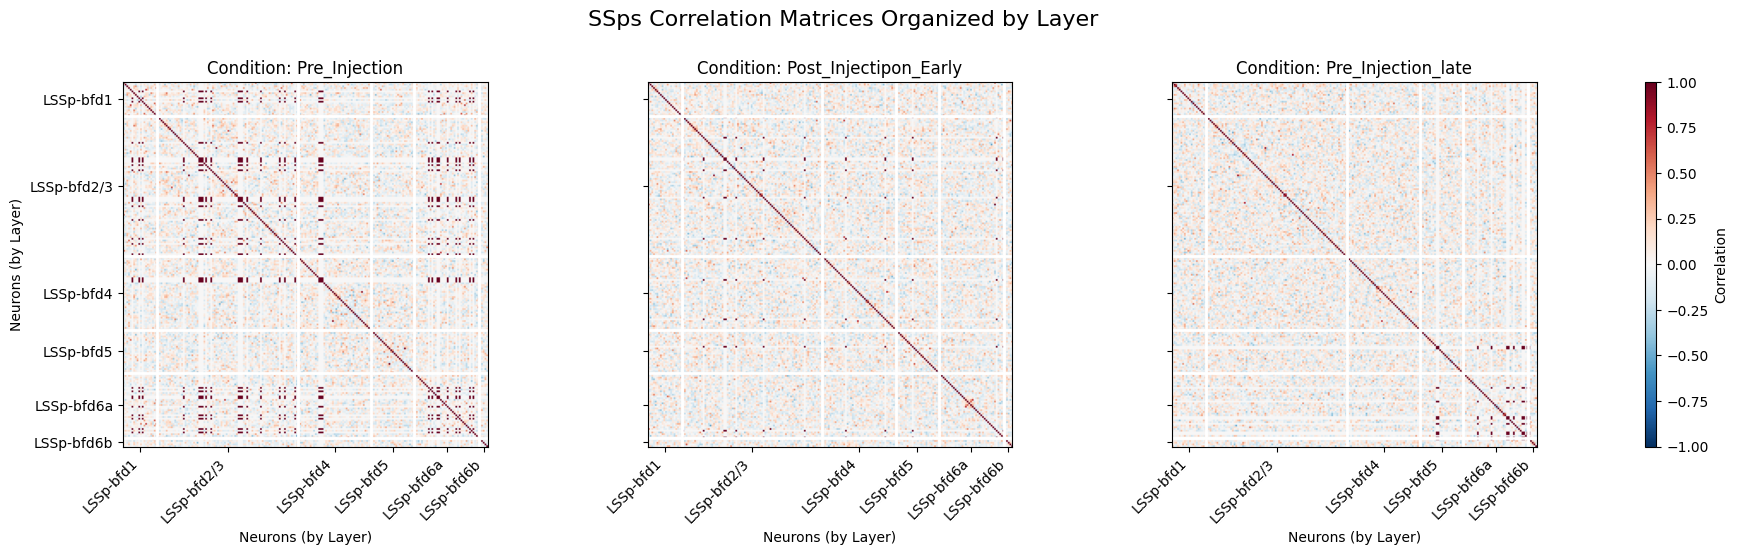

In [8]:
reg = "SSp"
matrices = []
for vis_epoch in vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs)
### cell type width 


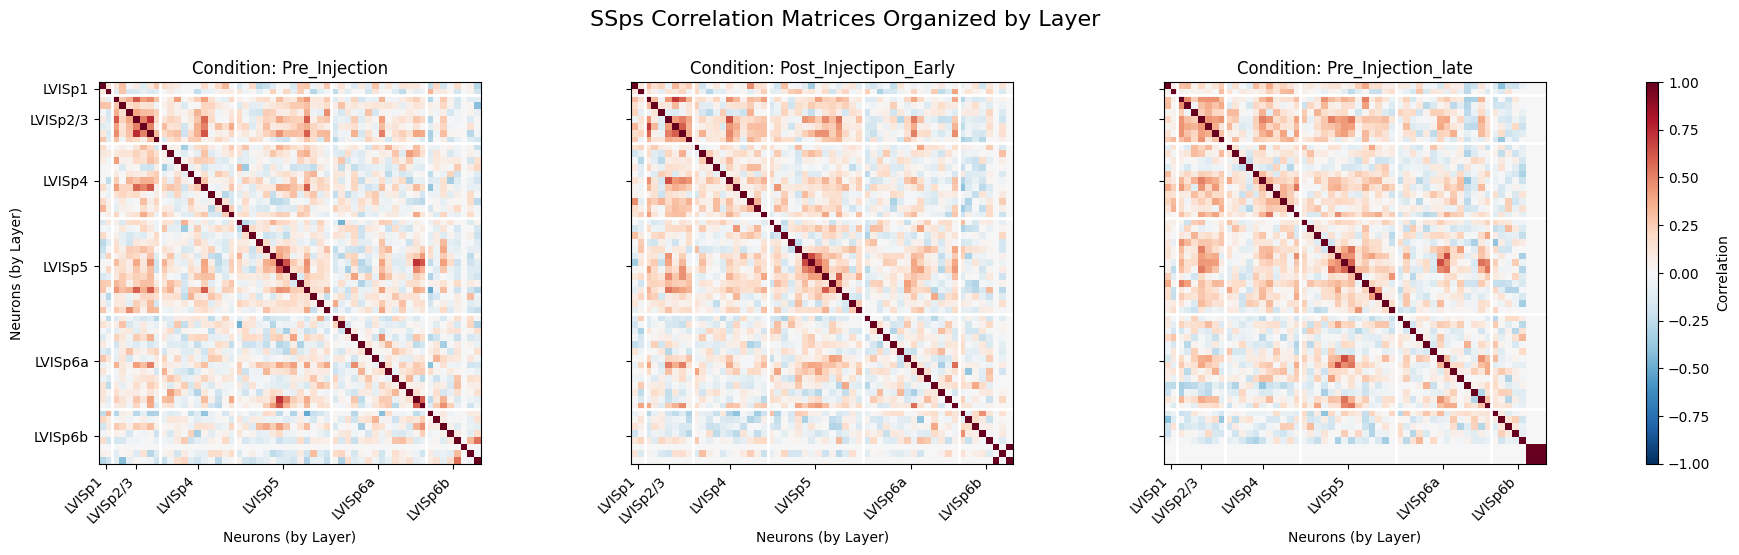

In [11]:
reg = "VISp"
matrices = []
for vis_epoch in vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs)

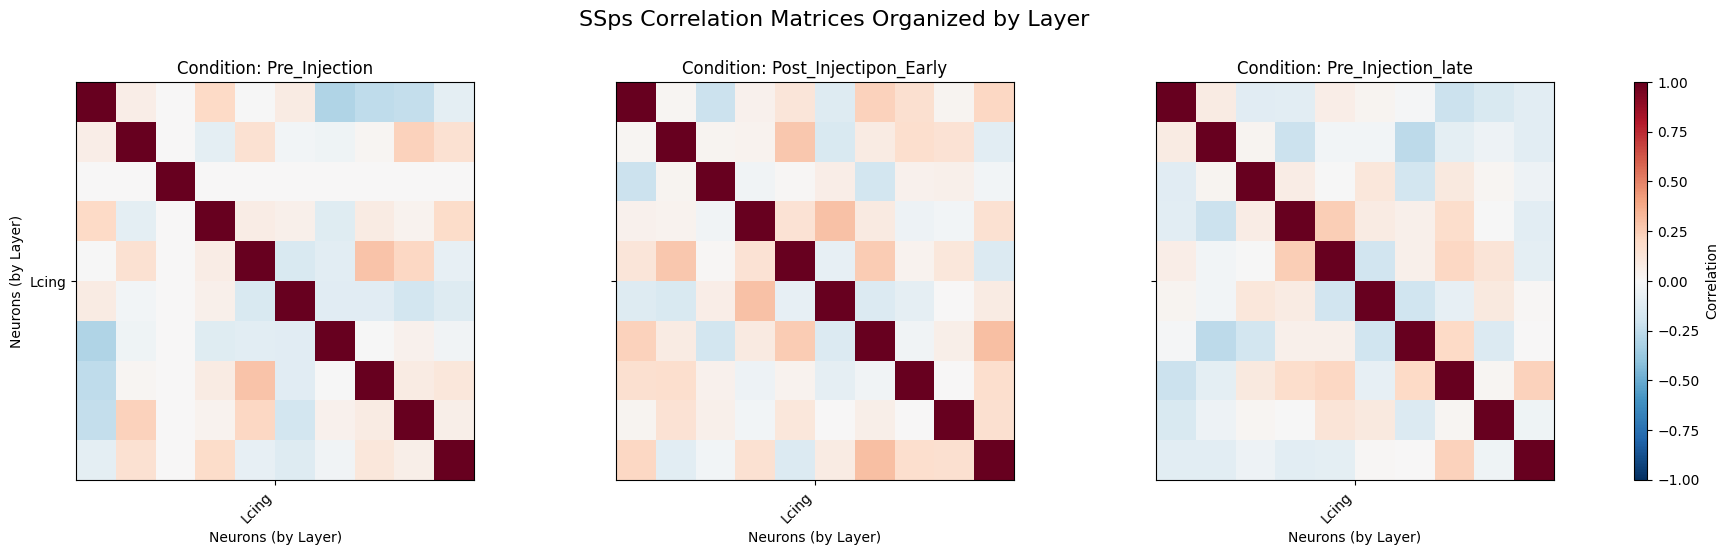

In [12]:
reg = "cing"
matrices = []
for vis_epoch in vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs)

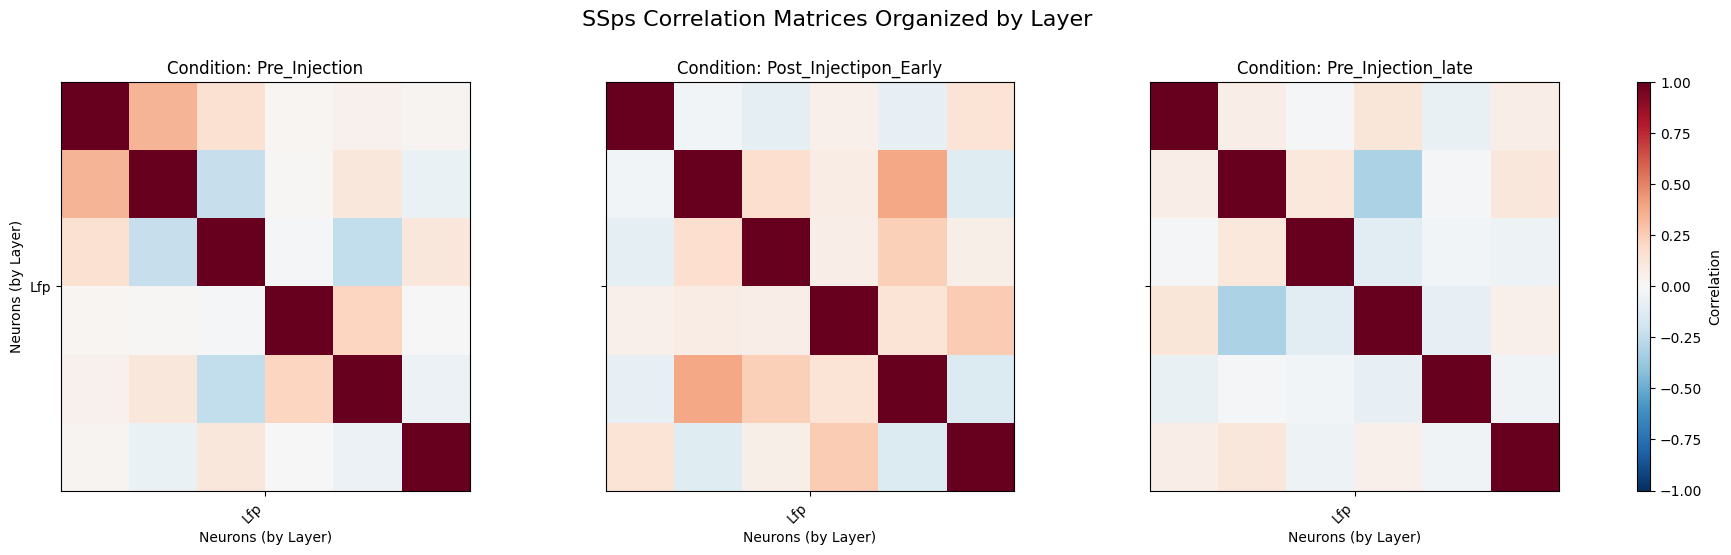

In [14]:
reg = "fp"
matrices = []
for vis_epoch in vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs)

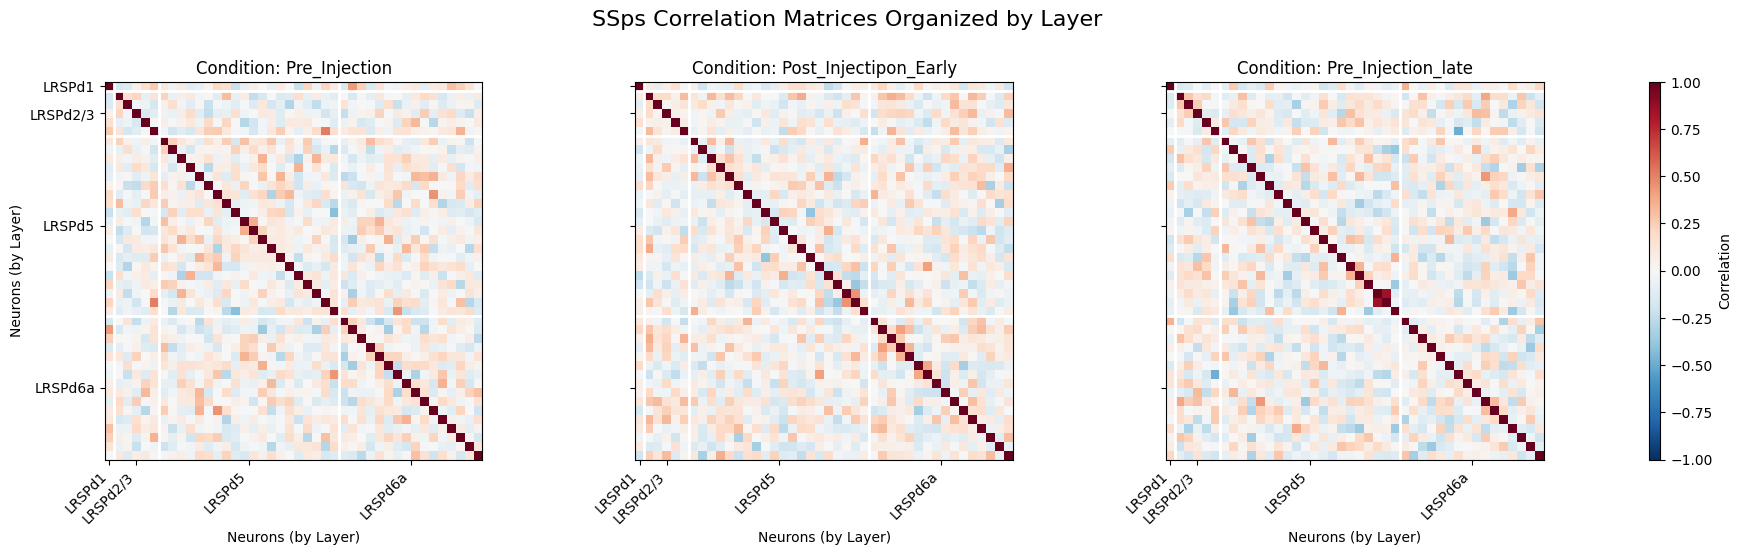

In [15]:
reg = 'RSPd'
matrices = []
for vis_epoch in vis_epochs:
    fr_rates = test_session.trial_data[vis_epoch][(7777,7777,7777)]
    test_sub = sr.subset_and_organize_matrices(test_session.region_labels, test_session.layer_labels, fr_rates,reg)
    v = sr.add_epsilon(test_sub[0], epsilon=1e-7)
    correlation_matrix = np.corrcoef(v)
    matrices.append(correlation_matrix)
layer_info = test_sub[2]
unique_layers = sorted(layer_info.keys())
plu.generate_matrices_comparison(matrices,layer_info,unique_layers,epochs)

In [ ]:
layers = []
for unit_idx in range(len(analysis_table)):
    spike_times = analysis_table.iloc[unit_idx]['Spontaneous_0_spikes']
    if spike_times is None or len(spike_times) == 0:
        continue
    layers.append(analysis_table.iloc[unit_idx]['layer'])
layers = np.array(layers)
fr_matrix = firing_rate_matrix_spon0.copy()
# 2. Sort neurons by layer
sorted_indices = np.argsort(layers)
sorted_layers = layers[sorted_indices]
fr_matrix_sorted = fr_matrix[sorted_indices]
# 3. Compute correlation matrix
corr_matrix = np.corrcoef(fr_matrix_sorted)
# 4. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='vlag', center=0, square=True, xticklabels=False, yticklabels=False)
plt.title("Neuron × Neuron Correlation (Grouped by Layer)", fontsize=14)
# 5. Optionally draw lines to show layer boundaries
unique_layers, counts = np.unique(sorted_layers, return_counts=True)
layer_boundaries = np.cumsum(counts)
# Draw horizontal and vertical lines to separate layers
for boundary in layer_boundaries[:-1]:
    plt.axhline(boundary, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(boundary, color='gray', linestyle='--', linewidth=0.5)
# 6. Compute tick positions (center of each group)
tick_positions = layer_boundaries - counts // 2
# :white_check_mark: Fix: Make sure tick_positions and labels match in length
assert len(tick_positions) == len(unique_layers)
# Add layer labels
plt.yticks(tick_positions, unique_layers, fontsize=10)
plt.xticks(tick_positions, unique_layers, fontsize=10, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
        fr_paths  = [os.path.join(ep_path, 'firing_rate2') for ep_path in epoch_paths]


In [2]:
main_path = '/scratch/'
epochs_path = '/scratch/RFMapping_2/'
fr_path = '/scratch/RFMapping_2/firing_rate2/'
trial_path = os.path.join(epochs_path,'trial_info.csv')
data_path = os.path.join(main_path,'data.pkl')
df_trials = pd.read_csv(trial_path,index_col='Unnamed: 0')
df_data = pd.read_pickle(data_path)

In [3]:
cell_labels = df_data.cell_type.values
region_labels = df_data.region.values
layer_labels = df_data.layer.values

In [4]:
sr_path = os.path.join(epochs_path,'firing_rates.pkl')
fr_data =pickle.load(open(sr_path, 'rb'))

In [33]:
groups = group_by_constant_elements(fr_data)

In [35]:
subsampled_fixed = subsample_groups(groups, sample_size=2)

NameError: name 'random' is not defined

In [ ]:
titles =  [i[0] for i in test[0]]
im2plot = [i[1] for i in test[0]]
reference_array = im2plot[0]  # The array to use for determining sort order

# Get the maximum value in each row
row_max_values = np.max(reference_array, axis=1)

# Get the indices that would sort by descending order (highest first)
sort_indices = np.argsort(row_max_values)[::-1]

# Apply this ordering to all arrays
sorted_array1 = im2plot[0][sort_indices]
sorted_array2 = im2plot[1][sort_indices]
sorted_array3 = im2plot[2][sort_indices]

In [ ]:
# Sort the arrays
reference_array = im2plot[0]
first_max_indices = np.argmax(reference_array, axis=1)
sort_indices = np.argsort(first_max_indices)

# Apply sorting to all arrays
sorted_im2plot = [arr[sort_indices] for arr in im2plot]

# Visualize before and after
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Original stacked image
original_stacked = np.hstack(im2plot)
im1 = ax1.imshow(original_stacked, aspect='auto', cmap='viridis')
ax1.set_title('Original Arrays')

# Sorted stacked image
sorted_stacked = np.hstack(sorted_im2plot)
im2 = ax2.imshow(sorted_stacked, aspect='auto', cmap='viridis')
ax2.set_title('Sorted by First Appearance of Maximum Value')

# Calculate tick positions based on actual array shapes
if 'titles' in locals():
    for ax in [ax1, ax2]:
        tick_positions = []
        array_widths = [arr.shape[1] for arr in im2plot]  # Get width of each array
        
        current_position = 0
        for width in array_widths:
            # Place tick at center of each array
            tick_positions.append(current_position + width/2 - 0.5)
            current_position += width
        
        tick_labels = [str(title) for title in titles]
        ax.set_xticks(tick_positions, tick_labels, rotation=45, ha='right')
        
        # Add separation lines based on actual widths
        current_position = 0
        for i, width in enumerate(array_widths[:-1]):  # Don't add line after last array
            current_position += width
            ax.axvline(x=current_position - 0.5, color='white', linestyle='-', linewidth=2, alpha=0.8)

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.tight_layout()
plt.show()

print(f"Rows are now ordered by column position of first max:")
print(f"Array shapes: {[arr.shape for arr in im2plot]}")
print(f"Array widths: {[arr.shape[1] for arr in im2plot]}")